<img src="https://ethical-principles-in-ai.github.io/static/media/epai_logo.e502dc0cef3c434c1abf.png" width="100">

# Deep Learning with Differential Privacy: Base Model

This model provides a baseline for comparison between various differential privacy techniques. It uses the DP-SGD techqniue, as described in [Abadi et al.](https://arxiv.org/abs/1607.00133). Guassian noise is applied within SGD to ensure the model cannot be reverse engineered using inputs/outputs, which makes the model differientially private.

*Written by Nicole Streltsov February 2023*

In [1]:
#check that we are on the correct python kernel 
from platform import python_version
print(python_version())

3.8.10


In [2]:
# imports
!pip --quiet install  objax # only for google colab
import jax
import jax.numpy as jn
import objax # to define a custom model with more control
import tensorflow as tf 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import gzip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data, Model Creation, and Function Definitions

In [4]:
#load from compressed pickle files
path = '' # 'chest-data #os.path.join(os.path.dirname(os.getcwd()), 'chest-data')

with gzip.open(os.path.join(path, 'chest_x_train.gz'), 'rb') as i:
    x_train = pickle.load(i)
with gzip.open(os.path.join(path, 'chest_x_val.gz'), 'rb') as i:
    x_valid = pickle.load(i)    
with gzip.open(os.path.join(path, 'chest_x_test.gz'), 'rb') as i:
    x_test = pickle.load(i)  
with gzip.open(os.path.join(path, 'chest_y_train.gz'), 'rb') as i:
    y_train = pickle.load(i)  
with gzip.open(os.path.join(path, 'chest_y_val.gz'), 'rb') as i:
    y_valid = pickle.load(i) 
with gzip.open(os.path.join(path, 'chest_y_test.gz'), 'rb') as i:
    y_test = pickle.load(i) 
        
print("numpy array shapes --> ", x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)             

numpy array shapes -->  (6808, 64, 64, 3) (586, 64, 64, 3) (585, 64, 64, 3) (6808, 1) (586, 1) (585, 1)


In [5]:
## Dummy dataset - cifar 10 for temporary testing
# # load data
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # dataset of 60000 32x32 coloured images

# print(x_test.shape, y_test.shape)
# x = np.concatenate([x_train, x_test], axis = 0)
# y = np.concatenate([y_train, y_test], axis = 0)

# # shuffle
# x, y = shuffle(x, y, random_state=0)

# # split into 80% train, 10% valid, 10% test
# x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, train_size=0.8)
# x_valid, x_test, y_valid, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5) # split remaining 20% into 10% and 10%

#convert to proper format for our model
def convert_x(x):
  return x.transpose(0, 3, 1, 2) / 255.0 # normalize, and ensure correct indicies for model

x_train = convert_x(x_train)
y_train = y_train.flatten()

x_valid = convert_x(x_valid)
y_valid = y_valid.flatten()

x_test = convert_x(x_test)
y_test = y_test.flatten()

In [25]:
# define cnn
class CNN(objax.Module):
  def __init__(self, channels, classes, size, kernel=3):
    self.conv1 = objax.nn.Sequential([objax.nn.Conv2D(channels, size, kernel), objax.functional.relu])
    self.conv2 = objax.nn.Sequential([objax.nn.Conv2D(size, 32, kernel), objax.functional.relu])
    self.fc1 = objax.nn.Sequential([objax.nn.Linear(8192, 128), objax.functional.relu])
    #self.fc2 = objax.nn.Sequential([objax.nn.Linear(128, classes), objax.functional.sigmoid])
    self.fc2 = objax.nn.Linear(128, classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv2(x), 2, 2)
    x = objax.functional.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x



'''
class CNN(objax.Module):
  def __init__(self, channels, classes, size, kernel):
    self.conv1 = objax.nn.Sequential([objax.nn.Conv2D(channels, size, kernel), objax.functional.relu])
    self.conv2 = objax.nn.Sequential([objax.nn.Conv2D(size, 512, kernel), objax.functional.relu])
    self.fc1 = objax.nn.Sequential([objax.nn.Linear(512, 70), objax.functional.relu])
    self.fc2 = objax.nn.Sequential([objax.nn.Linear(70, 8), objax.functional.relu])
    self.fc3 = objax.nn.Linear(8, classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv1(x), 2, 2)
    x = self.conv2(x)
    x = x.mean((2,3)) #global average pooling 
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x
'''


'\nclass CNN(objax.Module):\n  def __init__(self, channels, classes, size, kernel):\n    self.conv1 = objax.nn.Sequential([objax.nn.Conv2D(channels, size, kernel), objax.functional.relu])\n    self.conv2 = objax.nn.Sequential([objax.nn.Conv2D(size, 512, kernel), objax.functional.relu])\n    self.fc1 = objax.nn.Sequential([objax.nn.Linear(512, 70), objax.functional.relu])\n    self.fc2 = objax.nn.Sequential([objax.nn.Linear(70, 8), objax.functional.relu])\n    self.fc3 = objax.nn.Linear(8, classes)\n\n  def __call__(self, x):\n    x = objax.functional.max_pool_2d(self.conv1(x), 2, 2)\n    x = self.conv2(x)\n    x = x.mean((2,3)) #global average pooling \n    x = self.fc1(x)\n    x = self.fc2(x)\n    x = self.fc3(x)\n    return x\n'

<Figure size 432x288 with 0 Axes>

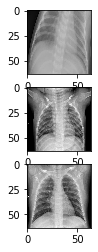

In [26]:
# show preview of dataset images
plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(x_train[0].transpose(1,2,0))
axarr[1].imshow(x_valid[0].transpose(1,2,0))
axarr[2].imshow(x_test[0].transpose(1,2,0))

In [27]:
#training loop helper function
def train_per_batch(x, y, lr, batch, train_op, predict):
  acc = 0
  shuffle_indicies = np.arange(len(x))
  np.random.shuffle(shuffle_indicies) #shuffle before running batches to remove correlation

  for i in range(0, x.shape[0], batch):
      batch_idxs = shuffle_indicies[i:i+batch]

      #run train_op step
      loss = float(train_op(x[batch_idxs], y[batch_idxs], lr)[0]) * len(batch_idxs)
      
      #store accuracy
      acc += (np.array(predict(x[batch_idxs]).argmax(1)).flatten() == y[batch_idxs]).sum()

  return acc

#training loop
def train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op, predict):
  train_accuracies = []
  valid_accuracies = []

  for epoch in range(1, epochs+1):
      train_loss = []
      valid_loss = []

      # batch training
      avg_train_acc = train_per_batch(x_train, y_train, lr, batch, train_op, predict) / x_train.shape[0]
      train_accuracies.append(avg_train_acc)
      
      # batch validation 
      avg_val_acc = train_per_batch(x_valid, y_valid, lr, batch, train_op, predict) / x_valid.shape[0]
      valid_accuracies.append(avg_val_acc)

      print('Epoch %d  Training Accuracy %.4f Validation Accuracy %.4f' % (epoch, avg_train_acc*100, avg_val_acc*100))
    
  return train_accuracies, valid_accuracies

## Train Regular CNN

In [38]:
# hyperparameters
epochs = 20
batch = 100
lr = 0.001
chest_ds_size = 64 #h/w of images in chest dataset

In [39]:
#define model
model_regular = CNN(channels = 3, classes = 2, size = chest_ds_size, kernel = 3) # classes = 10 for cifar10

#define loss
def loss_fn_regular(x, y):
    return objax.functional.loss.cross_entropy_logits_sparse(model_regular(x), y).mean()

#define prediction function (to get results of model training)
predict_regular = objax.Jit(lambda x: objax.functional.softmax(model_regular(x)), model_regular.vars())

# define 'forward' operation.
gv_regular = objax.GradValues(loss_fn_regular, model_regular.vars()) #function that calculates gradient
tv_regular = objax.ModuleList(objax.TrainRef(x) for x in model_regular.vars().subset(objax.TrainVar)) #trainable variables

def train_op_regular(x, y, lr):
    g, v = gv_regular(x, y) # apply gradient
    
    # ** optimzer: SGD **
    for grad, params in zip(g, tv_regular.vars()):
      params.value -= jn.multiply(grad, lr) #jax speeds up computation

    return v # v is the loss

train_op_regular = objax.Jit(train_op_regular, gv_regular.vars() + tv_regular.vars()) # compile train_op to make it faster

In [40]:
# train without differential privacy (dp)
train_accuracies_regular, valid_accuracies_regular = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_regular, predict_regular)

Epoch 1  Training Accuracy 65.8343 Validation Accuracy 73.8908
Epoch 2  Training Accuracy 74.0306 Validation Accuracy 74.4027
Epoch 3  Training Accuracy 79.0247 Validation Accuracy 75.0853
Epoch 4  Training Accuracy 83.2256 Validation Accuracy 78.1570
Epoch 5  Training Accuracy 85.5905 Validation Accuracy 79.0102
Epoch 6  Training Accuracy 88.3226 Validation Accuracy 82.7645
Epoch 7  Training Accuracy 90.2027 Validation Accuracy 86.3481
Epoch 8  Training Accuracy 91.0253 Validation Accuracy 86.8601
Epoch 9  Training Accuracy 91.7009 Validation Accuracy 89.0785
Epoch 10  Training Accuracy 92.1269 Validation Accuracy 89.2491
Epoch 11  Training Accuracy 92.3032 Validation Accuracy 89.0785
Epoch 12  Training Accuracy 92.7438 Validation Accuracy 90.6143
Epoch 13  Training Accuracy 92.9054 Validation Accuracy 91.6382
Epoch 14  Training Accuracy 93.1110 Validation Accuracy 92.1502
Epoch 15  Training Accuracy 93.0082 Validation Accuracy 91.4676
Epoch 16  Training Accuracy 93.4048 Validation Ac

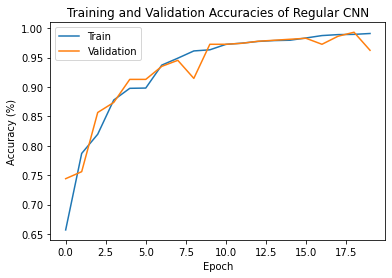

In [33]:
plt.title("Training and Validation Accuracies of Regular CNN")
plt.plot(train_accuracies_regular, label="Train")
plt.plot(valid_accuracies_regular, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [41]:
test_accuracy_regular = (np.array(predict_regular(x_test).argmax(1)).flatten() == y_test).sum()
print("Test Accuracy of Regular Model: ", 100*test_accuracy_regular/x_test.shape[0])

Test Accuracy of Regular Model:  91.11111111111111


## Train CNN with Differential Privacy

In train_op_dp, add gaussian noise and gradient clipping


In [52]:
# hyperparameters
epochs = 20
batch = 100
lr = 0.001
sigma = 4 # noise scale
C = 80 # gradient norm (Best C = median of the norms of the unclipped gradients) - mean was 79.5 after running with C=100
L = int(np.sqrt(len(x_train))) # L = √ N is the best group size

In [53]:
#define model
model_dp = CNN(channels = 3, classes = 2, size = chest_ds_size, kernel = 3)

#define loss
def loss_fn_dp(x, y):
    return objax.functional.loss.cross_entropy_logits_sparse(model_dp(x), y).mean()

#define prediction function (to get results of model training)
predict_dp = objax.Jit(lambda x: objax.functional.softmax(model_dp(x)), model_dp.vars())

# define 'forward' operation.
gv_dp = objax.GradValues(loss_fn_dp, model_dp.vars()) #dictionary that stores gradients
tv_dp = objax.ModuleList(objax.TrainRef(x) for x in model_dp.vars().subset(objax.TrainVar)) #trainable variables
unclipped_grad = jn.arange(len(tv_dp.vars())*epochs) #store in list, to find best C

def train_op_dp(x, y, lr):
    g, v = gv_dp(x, y) # apply gradient

    # ** optimzer: DP-SGD **

    i = 0 # which model variable
    for grad, params in zip(g, tv_dp.vars()):

      # get random "lot (L)" of examples to add noise to:
      lot_idxs = np.random.choice(len(x), L)
      g_lot, __ = gv_dp(x[lot_idxs], y[lot_idxs]) #get grad only for lot
      grad = g_lot[i]
    
      #gradient clipping
      norm = jn.linalg.norm(grad)
      unclipped_grad.at[i].set(norm) #store unlcipped gradients
      grad_clipped = grad / jn.maximum(jn.empty(jn.shape(norm)) + 1, norm/C)

      #apply guassian
      mu = 0
      std = sigma*C
      key = jax.random.PRNGKey(0) # to ensure guassian stays the same for all runs
      guassian = mu + std * jax.random.normal(key, jn.shape(grad_clipped))
      grad_w_guassian = jn.multiply(1/L, jn.add(grad_clipped, guassian))
      
      #update params
      params.value -= jn.multiply(grad_clipped, lr) 

      i+=1

    return v # v is the loss

train_op_dp = objax.Jit(train_op_dp, gv_dp.vars() + tv_dp.vars()) # compile train_op to make it faste

In [54]:
# train with differential privacy
train_accuracies_dp, valid_accuracies_dp = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_dp, predict_dp)

print ("---- For hyperparameter tuning: ----")
print("mean of unclipped gradients -> ", jn.mean(unclipped_grad))

Epoch 1  Training Accuracy 71.5041 Validation Accuracy 74.4027
Epoch 2  Training Accuracy 76.5276 Validation Accuracy 76.4505
Epoch 3  Training Accuracy 81.8743 Validation Accuracy 74.9147
Epoch 4  Training Accuracy 85.8549 Validation Accuracy 82.4232
Epoch 5  Training Accuracy 88.8367 Validation Accuracy 84.8123
Epoch 6  Training Accuracy 89.6298 Validation Accuracy 85.8362
Epoch 7  Training Accuracy 91.1575 Validation Accuracy 89.5904
Epoch 8  Training Accuracy 91.0840 Validation Accuracy 89.5904
Epoch 9  Training Accuracy 91.2309 Validation Accuracy 90.1024
Epoch 10  Training Accuracy 92.4060 Validation Accuracy 91.9795
Epoch 11  Training Accuracy 92.0828 Validation Accuracy 92.1502
Epoch 12  Training Accuracy 92.2885 Validation Accuracy 91.9795
Epoch 13  Training Accuracy 92.9935 Validation Accuracy 93.3447
Epoch 14  Training Accuracy 93.1992 Validation Accuracy 93.1741
Epoch 15  Training Accuracy 93.1992 Validation Accuracy 90.9556
Epoch 16  Training Accuracy 93.3020 Validation Ac

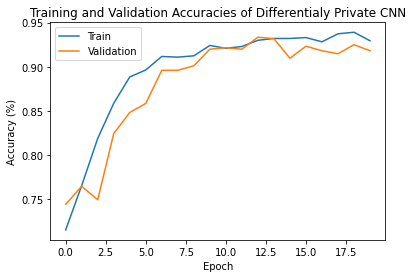

In [55]:
plt.title("Training and Validation Accuracies of Differentialy Private CNN")
plt.plot(train_accuracies_dp, label="Train")
plt.plot(valid_accuracies_dp, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [56]:
test_accuracy_dp = (np.array(predict_dp(x_test).argmax(1)).flatten() == y_test).sum()
print("Test Accuracy of Regular Model: ", 100*test_accuracy_dp/x_test.shape[0])

Test Accuracy of Regular Model:  93.16239316239316
